# Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in python using two different techniques:

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
1. Roberta Pretrained Model from 
1. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
df = pd.read_csv('../input/yelp-restaurant-reviews/Yelp Restaurant Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(19896, 4)
(500, 4)


In [3]:
# We are adding a new columns 'Unique Id' which will be helpful in this SENTIMENT ANALYSIS
df = df.reset_index().rename(columns={'index': 'Unique Id'})

In [4]:
df.head()

,Unique Id,Yelp URL,Rating,Date,Review Text
0,0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...


# Quick EDA

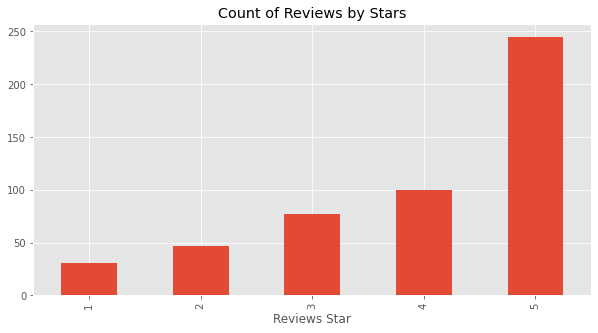

In [5]:
ax = df['Rating'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars',
                                            figsize=(10,5))
ax.set_xlabel('Reviews Star')
plt.show()

# Basic NLTK

In [6]:
example = df['Review Text'][37]
print(example)

This ice cream was exceptionally good. I would so come back here next time I'm in PHX. Think of getting soft serve ice cream mixed in with you favorite cereal... this is the place to go!


In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This',
 'ice',
 'cream',
 'was',
 'exceptionally',
 'good',
 '.',
 'I',
 'would',
 'so']

In [8]:
tageed = nltk.pos_tag(tokens)
tageed[:10]

[('This', 'DT'),
 ('ice', 'NN'),
 ('cream', 'NN'),
 ('was', 'VBD'),
 ('exceptionally', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('I', 'PRP'),
 ('would', 'MD'),
 ('so', 'RB')]

In [9]:
entities = nltk.chunk.ne_chunk(tageed)
entities.pprint()

(S
  This/DT
  ice/NN
  cream/NN
  was/VBD
  exceptionally/RB
  good/JJ
  ./.
  I/PRP
  would/MD
  so/RB
  come/VB
  back/RB
  here/RB
  next/JJ
  time/NN
  I/PRP
  'm/VBP
  in/IN
  (ORGANIZATION PHX/NNP)
  ./.
  Think/NNP
  of/IN
  getting/VBG
  soft/JJ
  serve/NN
  ice/NN
  cream/NN
  mixed/VBD
  in/IN
  with/IN
  you/PRP
  favorite/VBP
  cereal/NN
  .../:
  this/DT
  is/VBZ
  the/DT
  place/NN
  to/TO
  go/VB
  !/.)


# Step 1. VADER Seniment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

* This uses a "bag of words" approach:
    1. Stop words are removed
    1. each word is scored and combined to a total score.

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
sia.polarity_scores("How are you doing")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [13]:
sia.polarity_scores("I am not very good")

{'neg': 0.466, 'neu': 0.534, 'pos': 0.0, 'compound': -0.3865}

In [14]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [15]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.836, 'pos': 0.164, 'compound': 0.7569}

In [16]:
df.head()

,Unique Id,Yelp URL,Rating,Date,Review Text
0,0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...


In [17]:
# Run the polarity score on the entire dataset
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review Text']
    my_id = row['Unique Id']
    result[my_id] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index': 'Unique Id'})
vaders = vaders.merge(df, how='left')

In [19]:
#Now we have sentiment score and metadata

vaders.head()

,Unique Id,neg,neu,pos,compound,Yelp URL,Rating,Date,Review Text
0,0,0.000,0.641,0.359,0.8803,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,1,0.022,0.660,0.318,0.9509,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,2,0.000,0.651,0.349,0.8803,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,3,0.020,0.752,0.227,0.9400,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,4,0.027,0.730,0.243,0.9924,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...


# Plot VADER results

Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

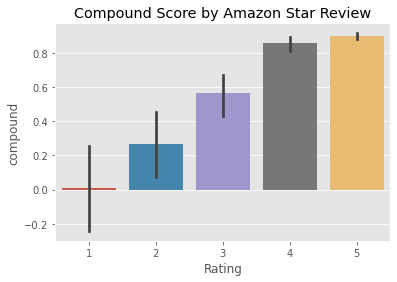

In [20]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compound Score by Amazon Star Review')

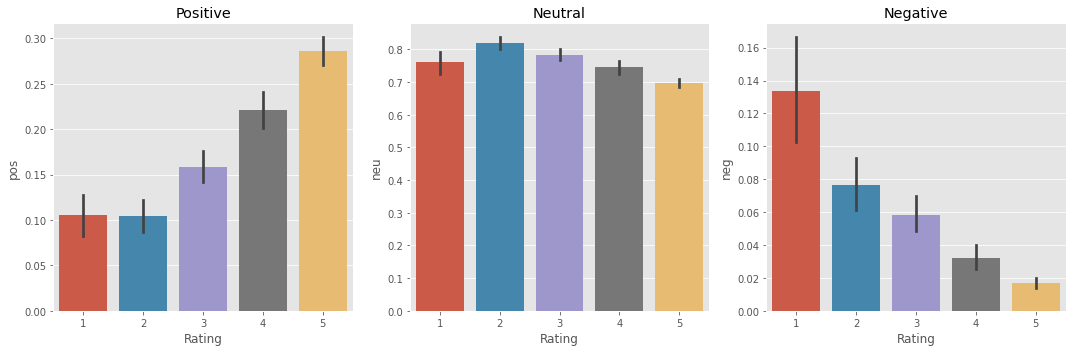

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()

#  Step 3. Roberta Pretrained Model

1. Use a model trained of a large corpus of data.
1. Transformer model accounts for the words but also the context related to other words.

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [24]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This ice cream was exceptionally good. I would so come back here next time I'm in PHX. Think of getting soft serve ice cream mixed in with you favorite cereal... this is the place to go!


{'neg': 0.0, 'neu': 0.836, 'pos': 0.164, 'compound': 0.7569}

In [25]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dct = {
    'robert_neg': scores[0],
    'robert_neu': scores[1],
    'robert_pos': scores[2]
    
}
print(scores_dct)

{'robert_neg': 0.001331767, 'robert_neu': 0.007379337, 'robert_pos': 0.9912892}


In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [27]:
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review Text']
        my_id = row['Unique Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        result[my_id] = both
    except RuntimeError:
        print(f"Broke for id {my_id}")

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 129
Broke for id 144
Broke for id 207
Broke for id 303
Broke for id 358
Broke for id 378
Broke for id 386
Broke for id 404


In [28]:
result_df = pd.DataFrame(result).T
result_df = result_df.reset_index().rename(columns={'index': 'Unique Id'})
result_df = result_df.merge(df, how='left')

# Compare Scores between models

In [29]:
result_df.head()

,Unique Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Yelp URL,Rating,Date,Review Text
0,0,0.000,0.641,0.359,0.8803,0.001766,0.009062,0.989172,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,1,0.022,0.660,0.318,0.9509,0.001860,0.011518,0.986622,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,2,0.000,0.651,0.349,0.8803,0.001350,0.008936,0.989715,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,3,0.020,0.752,0.227,0.9400,0.002148,0.008291,0.989561,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,4,0.027,0.730,0.243,0.9924,0.001501,0.015955,0.982544,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...


# Step 3. Combine and compare

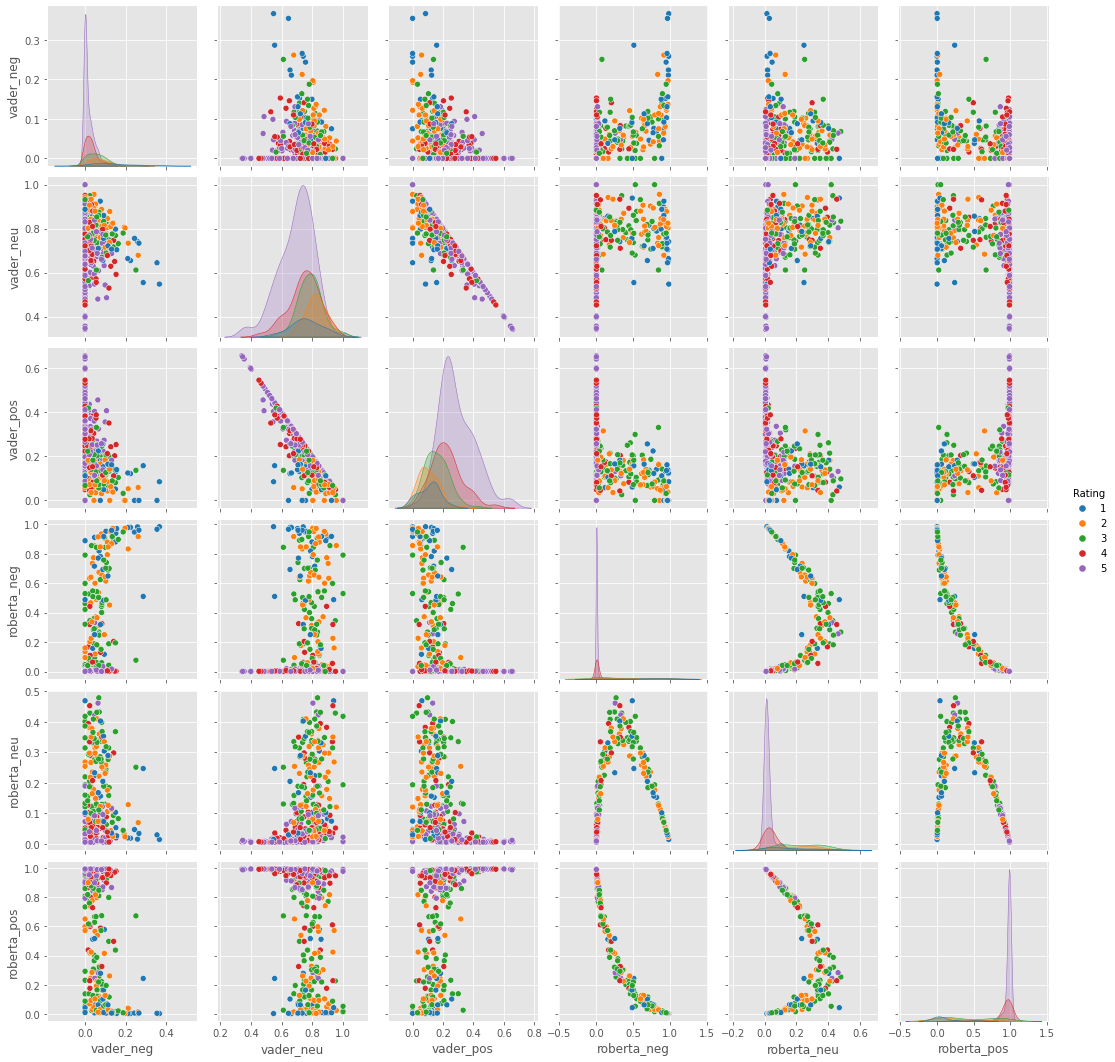

In [30]:
sns.pairplot(data=result_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Rating',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

* Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [31]:
result_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review Text'].values[0]

'Don\'t send your child in alone. The girl behind the counter told our grandson the machine was broken so his kid cup was filled only one-third of the way (about 5 tablespoons) and watery, although he still paid full price and tipped. When he returned to the car he was obviously disappointed so I went in to ask about it. The shift manager told me that\'s how they come now and then added, "Have a nice day." I guess rudeness and minion size portions is how they roll! As for us, we walked over to Culliver\'s where my grandson got a real size cup of ice cream with great customer service!'

In [32]:
result_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review Text'].values[0]

"We went to Carlos after a delicious lunch at Buddy V's. Beautiful place and pretty pastries, but when we got to our hotel and tried them everything was terrible, and that's me being nice. We had a brownie, super dry, a shortbread/sugar cookie w chocolate icing and choc chip cookie. Both cookies were sooooo dry and we just couldn't believe how bad they were. The packaging and all were so pretty but looks were DECEIVING!"

In [33]:
# nevative sentiment 5-Star view

In [34]:
result_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review Text'].values[0]

'I came across this after eating some poke at the same plaza. The brightness and the decor caught my eye. After looking at their simple menu I understood their concept. I chose fruity pebbles for the milkshake mix in and that nostalgia hit me. Oh those kids memories! The milkshake was flavorful and soft. I had a sample of their matcha late and it was on point: not too sweet and strong matcha taste. The thing that bothered me was that the place was packed and I had to share the table with another party.'

In [35]:
result_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review Text'].values[0]

"You might think you know what good cake is. But until you have tried Carlo's Bakery cakes you are dead wrong. The best cake. Moist dense and full of flavor. And don't get me started on the texture of the cream in the lobster tails. It's worth the trip to the second floor in the Venetian Grand Canal Shoppes."

# Extra: The Transformers Pipeline

* Quick & easy way to run sentiment predictions

In [36]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

2023-01-05 15:22:50.347084: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [37]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

# The End